# Estimating Correlations between Clinical Trials Outcomes (Single Phase)

Sergey Zhuk, 23.03.2021


The document contains the code used in the estimation for the following paper:

* Rey, Alexey, Olga Rozanova, and Sergey Zhuk. “Estimating Correlations between Vaccine Clinical Trial Outcomes,” 2021.

This document considers a simplified case in which the all phases clinical trials of a drug/vaccine are combined into a single phase. The code for the "three phases" you can find in *ctcorrelations-three-phases.ipynb*.

## 1. Model Overview

*(You can find a more detailed description in the paper).*

* There are K diseases ($k=1,\dots,K$) and $n^{k}$ vaccine candidates for disease $k$.

* The outcome of the clinicals trial for a given candidate can be aggregated into a continuous "quality" measure $Y_{i}^{k}$.

* If $Y_{i}^{k}>\mu$, then the clinical trial is successful, and the vaccine candidate $i$ is approved.

* $Y_{i}^{k}\sim \mathcal{N}(0, 1)$ and the vector $\{Y_{i}^{k}\}$ for $k=1,\dots,K, i=1,\dots,n^{k}$ has the multivariate normal distribution (with possibly correlated outcomes for different vaccine candidates).

* To represent the correlation matrix, we use factor models. For example, if correlation between vaccine candidates within the same disease is $\rho$ this can be expressed as:
$$Y_{i}^{k}=\sqrt{\rho}\cdot F^{k}+\sqrt{1-\rho}\cdot\varepsilon_{i}^{k}$$
$$\varepsilon_{i}^{k},F^{k}\sim\mathcal{N}(0,1)\ iid$$

* The "quality" $Y_{i}^{k}$ is a latent variable, which is not directly observable. We observe only the number of successful candidates for each disease $S^k$ defined as:

$$
X_{i}^{k}=\left\{\begin{array}{ll}
1 & if\ Y_{i}^{k}\ge\mu\\
0 & if\ Y_{i}^{k}<\mu
\end{array}\right.
\qquad S^{k}=\sum_{i=1}^{n_{k}}X_{i}^{k}$$

* The correlations between $Y_{i}^{k}$ affect the distribution of $S^k$, which allows us to estimate these correlations.

## 2. Data

To illustrate our methodology we estimate correlations based on the data from:
* Lo, Andrew W, Kien Wei Siah, and Chi Heem Wong. “Estimating Probabilities of Success of Vaccine and Other Anti-Infective Therapeutic Development Programs.” Working Paper. NBER, May 2020. https://doi.org/10.3386/w27176.

We use table 3 (for industry-sponsored vaccine development), which is reproduced below.
* *P1 Paths, P2 Paths, P3 Paths:* the number of projects with the known outcome of a given phase.
* *PoS12, PoS23, Pos3A:* the share of projects successfully transitioned to the next phase (A - means "regulatory acceptance").
* *Paths:* the number of projects with the known overall outcome.
* *PoS1A:* the share of overall succesfull projects (that reached regulatory acceptance).

For the simplified single phase estimation we rely only the overall outcomes from *Paths* and *PoS1A*. The code below constructs "*outcomes*" matrix out of these two columns (only we replace the share of successful project with the number of them). 

In [1]:
import numpy as np
import pandas as pd

data = pd.DataFrame(
    [['Bacterial Skin Infection',12,83.3,10.8,7,14.3,13.2,0.0,0.0,1,0.0,0.0,9,0.0,0.0],
    ['Chikungunya',6,83.3,15.2,0,0.0,0.0,0.0,0.0,0,0.0,0.0,1,0.0,0.0],
    ['Clostridium difficile',6,100.0,0.0,6,33.3,19.2,0.0,0.0,0,0.0,0.0,4,0.0,0.0],
    ['Cytomegalovirus Infection (CMV)',14,57.1,13.2,3,33.3,27.2,0.0,0.0,0,0.0,0.0,8,0.0,0.0],
    ['Ebola',13,53.8,13.8,7,57.1,18.7,28.6,20.2,2,100.0,0.0,11,18.2,11.6],
    ['Hepatitis B Virus (HBV)',213,94.8,1.5,187,74.9,3.2,54.5,3.7,132,77.3,3.6,190,53.7,3.6],
    ['Hepatitis C Virus (HCV)',27,70.4,8.8,15,0.0,0.0,0.0,0.0,0,0.0,0.0,23,0.0,0.0],
    ['Human Immunodeficiency Virus (HIV)',181,65.2,3.5,95,36.8,4.9,0.0,0.0,21,0.0,0.0,144,0.0,0.0],
    ['Human Papillomavirus (HPV)',120,88.3,2.9,69,52.2,6.0,36.2,6.1,30,83.3,6.8,77,32.5,5.3],
    ['Intra-abdominal Infections',1,100.0,0.0,1,100.0,0.0,0.0,0.0,1,0.0,0.0,1,0.0,0.0],
    ['Japanese Encephalitis',35,100.0,0.0,35,71.4,7.6,65.7,8.1,24,95.8,4.1,34,67.6,8.0],
    ['Marburg',3,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,3,0.0,0.0],
    ['Middle East Respiratory Syndrome (MERS)',4,50.0,25.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,2,0.0,0.0],
    ['Monkeypox',1,100.0,0.0,1,100.0,0.0,100.0,0.0,1,100.0,0.0,1,100.0,0.0],
    ['Norovirus',6,100.0,0.0,5,0.0,0.0,0.0,0.0,0,0.0,0.0,5,0.0,0.0],
    ['Otitis Media',23,95.7,4.3,22,81.8,8.2,45.5,10.6,18,55.6,11.7,23,43.5,10.3],
    ['Rabies',47,91.5,4.1,40,87.5,5.2,65.0,8.1,30,86.7,6.2,39,66.7,7.5],
    ['Respiratory Infections',640,79.1,1.6,465,66.9,2.2,50.1,2.4,287,81.2,2.3,575,40.5,2.0],
    ['Rotavirus',72,97.2,1.9,70,91.4,3.3,68.6,6.0,53,90.6,4.0,61,78.7,5.2],
    ['Sepsis',13,38.5,13.5,5,80.0,17.9,0.0,0.0,4,0.0,0.0,13,0.0,0.0],
    ['Severe Acute Respiratory Syndrome (SARS)',1,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,1,0.0,0.0],
    ['Smallpox',11,81.8,11.6,8,62.5,17.1,50.0,17.7,5,80.0,17.9,10,40.0,15.5],
    ['Urinary Tract Infections',3,100.0,0.0,3,100.0,0.0,0.0,0.0,1,0.0,0.0,1,0.0,0.0],
    ['West Nile Virus (WNV)',4,25.0,21.7,1,100.0,0.0,0.0,0.0,1,0.0,0.0,4,0.0,0.0],
    ['Yellow Fever',30,90.0,5.5,26,73.1,8.7,57.7,10.5,15,100.0,0.0,25,60.0,9.8],
    ['Zika',2,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,2,0.0,0.0],
    ['Others',350,87.1,1.8,268,63.4,2.9,47.0,3.2,142,88.7,2.7,285,44.2,2.9],
    ['Total',1838,82.5,0.9,1339,65.4,1.3,45.9,1.4,768,80.1,1.4,1552,39.6,1.2]],
    columns = ['Disease','P1 Paths','PoS12','SE12','P2 Paths','PoS23','SE23','PoS2A','SE2A','P3 Paths','PoS3A','SE3A','Paths','PoS1A','SE1A']
)
display(data)
data = data[np.logical_and(data['Disease'] != 'Total', data['Disease'] != 'Others')] # remove 'Others' and 'Total'
data['S1A'] = np.round(data['Paths']*data['PoS1A']/100).astype(int)
outcomes = np.array(data[['Paths', 'S1A']]) # construct outcomes matrix
data[['Disease','Paths', 'S1A']]

,Disease,P1 Paths,PoS12,SE12,P2 Paths,PoS23,SE23,PoS2A,SE2A,P3 Paths,PoS3A,SE3A,Paths,PoS1A,SE1A
0,Bacterial Skin Infection,12,83.3,10.8,7,14.3,13.2,0.0,0.0,1,0.0,0.0,9,0.0,0.0
1,Chikungunya,6,83.3,15.2,0,0.0,0.0,0.0,0.0,0,0.0,0.0,1,0.0,0.0
2,Clostridium difficile,6,100.0,0.0,6,33.3,19.2,0.0,0.0,0,0.0,0.0,4,0.0,0.0
3,Cytomegalovirus Infection (CMV),14,57.1,13.2,3,33.3,27.2,0.0,0.0,0,0.0,0.0,8,0.0,0.0
4,Ebola,13,53.8,13.8,7,57.1,18.7,28.6,20.2,2,100.0,0.0,11,18.2,11.6
5,Hepatitis B Virus (HBV),213,94.8,1.5,187,74.9,3.2,54.5,3.7,132,77.3,3.6,190,53.7,3.6
6,Hepatitis C Virus (HCV),27,70.4,8.8,15,0.0,0.0,0.0,0.0,0,0.0,0.0,23,0.0,0.0
7,Human Immunodeficiency Virus (HIV),181,65.2,3.5,95,36.8,4.9,0.0,0.0,21,0.0,0.0,144,0.0,0.0
8,Human Papillomavirus (HPV),120,88.3,2.9,69,52.2,6.0,36.2,6.1,30,83.3,6.8,77,32.5,5.3
9,Intra-abdominal Infections,1,100.0,0.0,1,100.0,0.0,0.0,0.0,1,0.0,0.0,1,0.0,0.0


,Disease,Paths,S1A
0,Bacterial Skin Infection,9,0
1,Chikungunya,1,0
2,Clostridium difficile,4,0
3,Cytomegalovirus Infection (CMV),8,0
4,Ebola,11,2
5,Hepatitis B Virus (HBV),190,102
6,Hepatitis C Virus (HCV),23,0
7,Human Immunodeficiency Virus (HIV),144,0
8,Human Papillomavirus (HPV),77,25
9,Intra-abdominal Infections,1,0


## 3. Axiliary Code

In [2]:
import time
import numpy as np
import scipy.integrate as integrate
import scipy.optimize as optimize
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import comb
from scipy.stats import chi2
from IPython.display import clear_output

def bnd(x, a, b): 
    # using sigmoid function transforms interval (-\infty,\infty) into interval (a, b)
    # is used below to restrict minimization to the interval (a, b)
    t = np.exp(-np.abs(x))
    return a+(b-a)*((x>0)*1+(x<=0)*t)/(1+t)

def stderrors(lf, p, dp, outcomes = outcomes): # is used to calculated standard errors
    k = list(dp.keys()); m = len(k)
    I = np.zeros((m, m)); dv = np.zeros(m)
    p0 = dict()
    for i in range(m):
        p0[k[i]] = p[k[i]]

    for d in range(len(outcomes)):
        for i in range(m):
            pa = p0.copy(); pb = p0.copy()
            pa[k[i]] = pa[k[i]] - dp[k[i]]
            pb[k[i]] = pb[k[i]] + dp[k[i]]
            la = lf(**pa, outcomes = outcomes[d:d+1])
            lb = lf(**pb, outcomes = outcomes[d:d+1])
            dv[i] = (lb-la)/2/dp[k[i]]
        for i in range(m):
            for j in range(m):
                I[i,j] = I[i,j] + dv[i]*dv[j]
    invI = np.linalg.inv(I)
    se = dict()
    for i in range(m):
        se[k[i]] = np.sqrt(invI[i, i])
    return se

def calc_time(dt): # report calculation time
    h = np.floor(dt/3600)
    m = np.floor((dt-h*3600)/60)
    s = dt - h * 3600 - m * 60
    return '{:.0f}:{:02.0f}:{:06.3f}'.format(h, m, s)

## 4. Estimation

### 4.1 Model (a). No correlation

Model:

$$Y_{i}^{k}=\varepsilon_{i}^{k}\ge\mu\qquad\varepsilon_{i}^{k}\sim\mathcal{N}(0,1)\ \ iid$$

We estimate $\mu$ with maximum likelihood.

In [3]:
def likelihood_a(mu, outcomes = outcomes):
    nd = len(outcomes)
    ns = outcomes[:,1]; nfail = outcomes[:,0] - outcomes[:,1]
    factor = comb(outcomes[:,0], outcomes[:,1])
    lk = 0
    p = norm.cdf(-mu)
    for i in range(0, nd):
        x = factor[i]*(p**ns[i])*((1-p)**nfail[i])
        if x == 0: return -np.inf
        lk += np.log(x)
    return lk

t0 = time.time()
resa = optimize.minimize(lambda t: -likelihood_a(t), x0 = 0)
dt = time.time() - t0
# dt = 0.007 # Intel Core i5-6500 CPU @ 3.20GHz, 8 Gb RAM, Windows 10
resa.l = -resa.fun
resa.p = {'mu': resa.x[0]}
resa.se = stderrors(likelihood_a, resa.p, dp = {'mu': 0.01}) 

print('Model (a), no correlation:'); 
print('    caclulation time:', calc_time(dt))

for k in resa.p.keys():
    print('    {} = {:.4f} ({:.4f})'.format(k, resa.p[k], resa.se[k]))
print('    log(likelihood) =', np.round(resa.l, 4))

Model (a), no correlation:
    caclulation time: 0:00:00.032
    mu = 0.2899 (0.0087)
    log(likelihood) = -175.5435


### 4.2 Model (b). Correlation $\rho$ for vaccine candidates within the same disease

Model:
$$Y_{i}^{k}=\sqrt{\rho}\cdot F^{k}+\sqrt{1-\rho}\cdot\varepsilon_{i}^{k}\ge\mu$$

$$F^k, \varepsilon_{i}^{k}\sim N(0,1)\ \ iid$$
We estimate both $\mu$ and $\rho$ with maximum likelihood.

In [4]:
def likelihood_b(mu, rho, outcomes = outcomes):
    nd = len(outcomes) # number of diseases
    sigma = np.sqrt(1-rho); beta = np.sqrt(rho)
    nsuccess = outcomes[:,1]; nfail = outcomes[:,0] - outcomes[:,1]
    factor = comb(outcomes[:,0], outcomes[:,1])
    lk = 0
    for i in range(0, nd):
        def g(F):
            p = norm.cdf((-mu + F*beta)/sigma)
            return factor[i]*(p**nsuccess[i])*((1-p)**nfail[i])*norm.pdf(F)
        x = integrate.quad(g, -np.inf, np.inf)[0]
        if x == 0: return -np.inf
        lk += np.log(x)
    return lk

def parameters_b(t):
    return {'mu': t[0], 'rho': bnd(t[1], 0, 0.95)}

t0 = time.time()
resb = optimize.minimize(lambda t: -likelihood_b(**parameters_b(t)), x0 = np.zeros(2))
dt = time.time() - t0
#dt = 46.106 # Intel Core i5-6500 CPU @ 3.20GHz, 8Gb RAM, Windows 10

resb.l = -resb.fun # likelihood
resb.p = parameters_b(resb.x) # parameters
resb.se = stderrors(likelihood_b, resb.p, dp = {'mu': 0.01, 'rho': 0.01}) #standard errors

print('Model (b), with correlation:'); 
print('    caclulation time:', calc_time(dt)) # 0:00:46.106 - office
for k in resb.p.keys():
    print('    {} = {:.4f} ({:.4f})'.format(k, resb.p[k], resb.se[k]))
print('\n    log(likelihood) =', np.round(resb.l, 4))
# LR test
LR = 2*(resb.l - resa.l); pvalue = 1 - chi2.cdf(LR,1)
print('    LR (model a) = {:.4f} (p-value = {:.4f})'.format(LR, pvalue))

Model (b), with correlation:
    caclulation time: 0:01:43.259
    mu = 0.7272 (0.2891)
    rho = 0.6744 (0.1848)

    log(likelihood) = -56.3397
    LR (model a) = 238.4076 (p-value = 0.0000)


## 5. Applications

### 5.1 Probability of Overall Success

Model (b): First, we calculate of success for a given difficulty factor $F$.

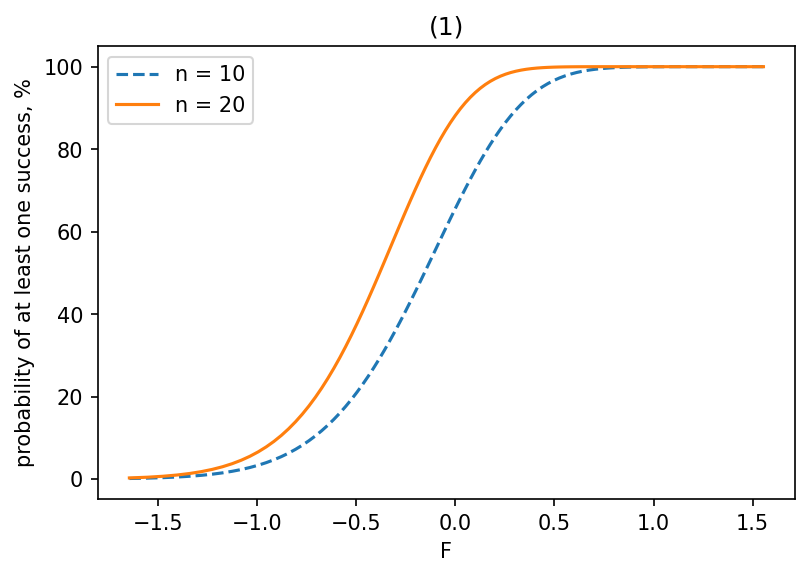

In [5]:
def vac_prob_F(mu, rho, F, n):
    sigma = np.sqrt(1-rho); beta = np.sqrt(rho)
    p = norm.cdf((- mu + beta*F)/sigma)
    return 1-(1-p)**n

quantile = np.arange(0.05, 0.95, 0.01)
F = norm.ppf(quantile)
prob1 = F.copy(); prob2 = F.copy()
for i in range(0, len(F)):
    prob1[i] = vac_prob_F(**resb.p, F = F[i], n = 10)
    prob2[i] = vac_prob_F(**resb.p, F = F[i], n = 20)

plt.figure(dpi = 150)
plt.plot(F, 100*prob1, '--', F, 100*prob2, '-')
plt.xlabel('F')
plt.ylabel('probability of at least one success, %')
plt.legend(['n = 10', 'n = 20'])
plt.title('(1)');

Now, we can calculate the overall probability by average over 
$$F~\sim\mathcal{N}(0,1)$$ and compare the results with model (a).

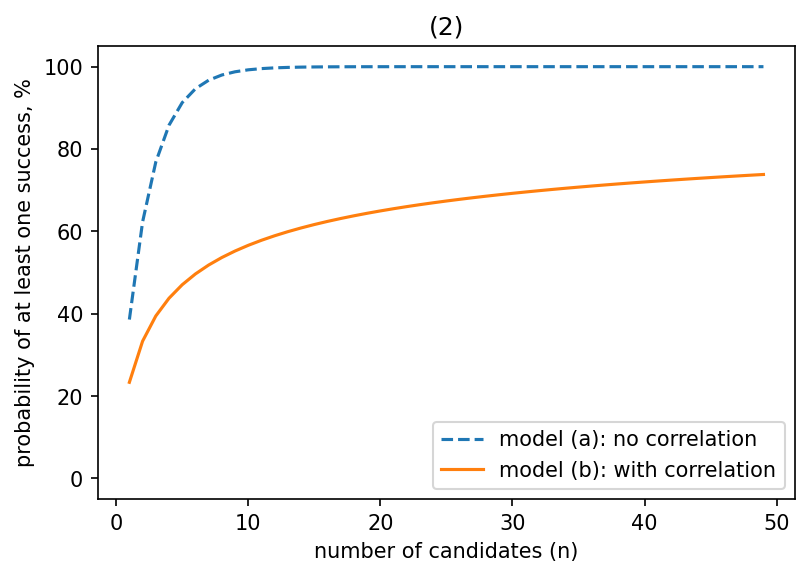

In [6]:
def vac_prob_a(mu, n):
    return 1 - norm.cdf(resa.p['mu'])**n

def vac_prob_b(mu, rho, n):
    return integrate.quad(lambda x: vac_prob_F(mu = mu, rho = rho, F = x, n = n)*norm.pdf(x), -np.inf, np.inf)[0]

n = np.arange(1, 50)
prob_a = np.zeros(len(n)); prob_b = np.zeros(len(n))

for i in range(0, len(n)):
    prob_a[i] = vac_prob_a(**resa.p, n = n[i])
    prob_b[i] = vac_prob_b(**resb.p, n = n[i])

plt.figure(dpi = 150)
plt.plot(n, 100*prob_a, '--', n, 100*prob_b, '-'); plt.ylim((-5, 105))
plt.xlabel('number of candidates (n)')
plt.ylabel('probability of at least one success, %')
plt.legend(['model (a): no correlation', 'model (b): with correlation'], loc = 'lower right');
plt.title('(2)');

### 5.2 Probability of Success for a Given Candidate

Suppose we have a new disease. Consider one specific vaccine/drug candidate. The code below calculates the probability that it will succeeed (that it will transition to success) for both estimated models. See the discussion in the paper about the origin of the difference.

In [7]:
# Model (a): no correlations
prob_a1 = vac_prob_a(**resa.p, n = 1)
prob_b1 = vac_prob_b(**resb.p, n = 1)

print('Model (a) single candidate success probability = {:.4f}%'.format(100*prob_a1))
# This, probability is exactly the same as the share of overall successful outcomes
n = sum(data['Paths']); s = sum(data['S1A'])
print('Share of overall successful outcomes = {}/{} = {}%'.format(s, n, 100*s/n))
print('\nModel (b) single candidate success probability = {:.4f}%'.format(100*prob_b1))

Model (a) single candidate success probability = 38.5951%
Share of overall successful outcomes = 489/1267 = 38.59510655090766%

Model (b) single candidate success probability = 23.3546%


### 5.3 Optimal Investment Strategy


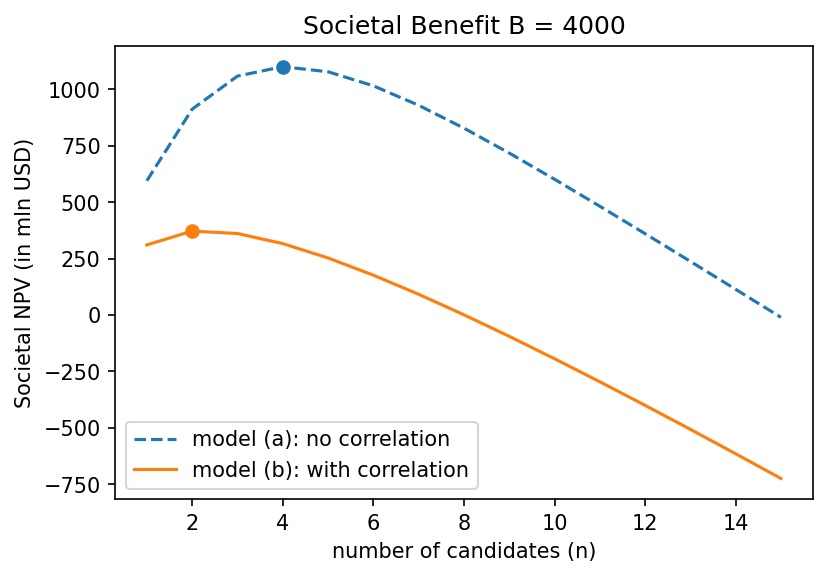

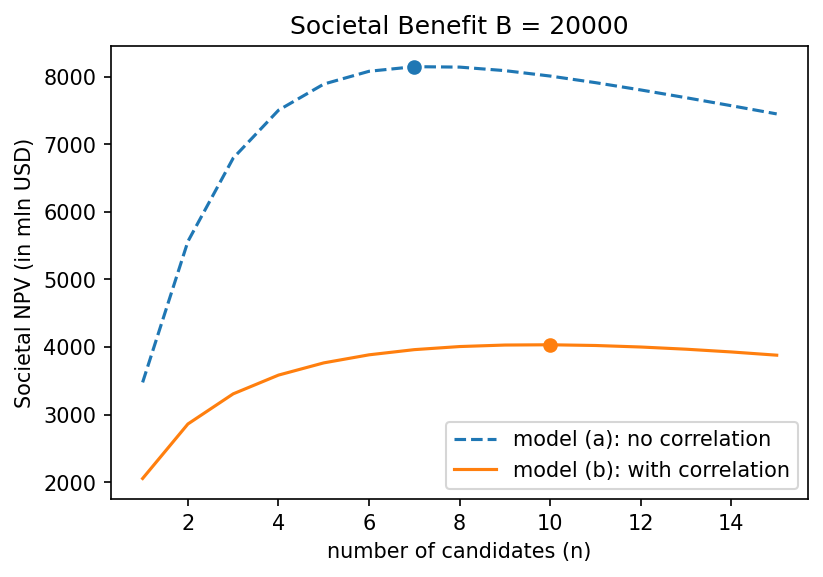

In [8]:
I = 125 # average cost of clinical trials per candidate (in mln USD)
B = [4000, 20000] # societal benefits from obtaining a successful drug/vaccine (in mln USD)
r = 0.1 # discount rate
T = 8 # number of years from the start till the end of clinical trials

n = np.arange(1, 16)
prob_a = np.zeros(len(n)); prob_b = np.zeros(len(n))
for i in range(0, len(n)):
    prob_a[i] = vac_prob_a(**resa.p, n = n[i])
    prob_b[i] = vac_prob_b(**resb.p, n = n[i])
    
for j in range(0, len(B)):
    NPV_a = B[j]*prob_a/((1+r)**T) - I*n
    NPV_b = B[j]*prob_b/((1+r)**T) - I*n
    plt.figure(dpi = 150)
    plt.plot(n, NPV_a, '--', n, NPV_b, '-'); #plt.ylim((-5, 105))
    plt.scatter(n[np.argmax(NPV_a)], NPV_a[np.argmax(NPV_a)])
    plt.scatter(n[np.argmax(NPV_b)], NPV_b[np.argmax(NPV_b)])
    plt.xlabel('number of candidates (n)')
    plt.ylabel('Societal NPV (in mln USD)')
    plt.legend(['model (a): no correlation', 'model (b): with correlation']);
    plt.title('Societal Benefit B = {}'.format(B[j]))

## 6. Simulations Studies

### 6.1 Simulation Study #1

We generate 100 samples for model (b):

$$Y_{i}^{k}=\sqrt{\rho}\cdot F^{k}+\sqrt{1-\rho}\cdot\varepsilon_{i}^{k}\ge\mu$$

with parameters $\mu = 0.5$ and $\rho = 0.5$.

Then we estimate parameters for each of these samples with maximum likelihood.

In [9]:
def generate_sample_b(model, n):
    K = len(n)
    sample = np.zeros((K, 2))
    F = np.random.normal(size = K)
    for k in range(0, K):
        sample[k, 0] = n[k]
        eps = np.random.normal(size = n[k])
        rho = np.sqrt(model['rho'])
        Y = np.sqrt(model['rho'])*F[k] + np.sqrt(1-model['rho'])*eps
        sample[k, 1] = sum(Y>=model['mu'])
    return sample


def sim_b(model, niter = 20, seed = 0):
    np.random.seed(seed)
    r = []    
    for it in range(0, niter):
        s = generate_sample_b(model, n = outcomes[:,0])
        resb_sim = optimize.minimize(lambda t: -likelihood_b(**parameters_b(t), outcomes = s), x0 = np.zeros(2))
        ri = parameters_b(resb_sim.x)
        se = stderrors(likelihood_b, ri, dp = {'mu': 0.01, 'rho': 0.01}, outcomes = s)
        for k in se.keys(): ri[k+'_se'] = se[k]
        ri['likelihood'] = -resb_sim.fun
        r.append(ri)
    r = pd.DataFrame(r)
    return r

if False:
    t0 = time.time()
    rs = sim_b({'mu': 0.5, 'rho': 0.5}, niter = 100)
    t1 = time.time()
    print('calculation time = ', calc_time(t0, t1))
else:
    rs = pd.DataFrame([
        {'mu': 0.23322778782657339, 'rho': 0.42148486308305827, 'mu_se': 0.16031318566714678, 'rho_se': 0.14417140533184727, 'likelihood': -64.78392053092661},
        {'mu': 0.9589576732642879, 'rho': 0.24814330220535036, 'mu_se': 0.1414566923297186, 'rho_se': 0.1177288689896577, 'likelihood': -51.175183540011176},
        {'mu': 0.5901573490585146, 'rho': 0.5970572287583932, 'mu_se': 0.1938184072625931, 'rho_se': 0.09550407962236541, 'likelihood': -57.66349855223188},
        {'mu': 0.7226738953114223, 'rho': 0.4266940647417242, 'mu_se': 0.2081401517970698, 'rho_se': 0.1373898591582612, 'likelihood': -57.455403822562836},
        {'mu': 0.5865091115074023, 'rho': 0.5076616119847143, 'mu_se': 0.17379816791441796, 'rho_se': 0.10165868515688752, 'likelihood': -59.888699150590824},
        {'mu': 0.5309245325929074, 'rho': 0.4309739213968233, 'mu_se': 0.16681409420194646, 'rho_se': 0.11547706883071103, 'likelihood': -61.223009624778065},
        {'mu': 0.40222778927021496, 'rho': 0.5221162201449021, 'mu_se': 0.16879102744266122, 'rho_se': 0.0965683823916519, 'likelihood': -62.97544861712546},
        {'mu': 0.5123868101700962, 'rho': 0.5418966504359322, 'mu_se': 0.19645716896462723, 'rho_se': 0.13696265269915212, 'likelihood': -61.0001096926115},
        {'mu': 0.607251099050426, 'rho': 0.44628529308861764, 'mu_se': 0.1605213348884081, 'rho_se': 0.07856602603847897, 'likelihood': -59.453373435860804},
        {'mu': 0.24700368514634197, 'rho': 0.3496796804221108, 'mu_se': 0.14969762920522578, 'rho_se': 0.15730334903710347, 'likelihood': -64.34046178987771},
        {'mu': 0.37377339158881073, 'rho': 0.5203693681361353, 'mu_se': 0.1720407081933925, 'rho_se': 0.10828971620983627, 'likelihood': -63.34633213704323},
        {'mu': 0.5157899259361592, 'rho': 0.5987324294638181, 'mu_se': 0.181472627901546, 'rho_se': 0.11178471897951797, 'likelihood': -60.64096707109681},
        {'mu': 0.6633630753128027, 'rho': 0.6490817115198882, 'mu_se': 0.19233331472779194, 'rho_se': 0.11680530813534647, 'likelihood': -57.050993255777385},
        {'mu': 0.5550229224051244, 'rho': 0.4051001307784981, 'mu_se': 0.15672034683973154, 'rho_se': 0.09897923199376653, 'likelihood': -60.62241028367169},
        {'mu': 0.495213606263613, 'rho': 0.42199735168553987, 'mu_se': 0.1580211435010851, 'rho_se': 0.14612784877369314, 'likelihood': -61.44397127717261},
        {'mu': 0.5903097963239259, 'rho': 0.5017932502644676, 'mu_se': 0.21100415112831294, 'rho_se': 0.17265266774620694, 'likelihood': -59.98539187819874},
        {'mu': 0.498311823355452, 'rho': 0.35822118850730394, 'mu_se': 0.20357740156812434, 'rho_se': 0.12017765797147281, 'likelihood': -61.26461624936981},
        {'mu': 0.7150612881862397, 'rho': 0.5101342532568237, 'mu_se': 0.19626985660712715, 'rho_se': 0.1731517652394168, 'likelihood': -56.98367174651453},
        {'mu': 1.036100809191028, 'rho': 0.2996871785417288, 'mu_se': 0.15879375546300337, 'rho_se': 0.12309740682392369, 'likelihood': -48.94858750155415},
        {'mu': 0.8463426118960061, 'rho': 0.26858679050626827, 'mu_se': 0.15189588227639297, 'rho_se': 0.10160582555435964, 'likelihood': -55.71377119718558},
        {'mu': 0.739349676221662, 'rho': 0.4990122690218472, 'mu_se': 0.17142297783373603, 'rho_se': 0.13598270898543166, 'likelihood': -56.42809321740228},
        {'mu': 0.4994964772213167, 'rho': 0.5589368743370818, 'mu_se': 0.1857961544866153, 'rho_se': 0.13973933171165426, 'likelihood': -61.13412943036128},
        {'mu': 0.5881735520272486, 'rho': 0.5824967188865074, 'mu_se': 0.18611246046951171, 'rho_se': 0.12217550068088767, 'likelihood': -58.72387652414792},
        {'mu': 0.8413204093871013, 'rho': 0.6878050896268185, 'mu_se': 0.19982947855955246, 'rho_se': 0.13066880512094275, 'likelihood': -50.32490090304833},
        {'mu': 0.21312490025780137, 'rho': 0.46269503439384696, 'mu_se': 0.1705064613899404, 'rho_se': 0.12794171927639994, 'likelihood': -65.14781051105592},
        {'mu': 0.332828908742866, 'rho': 0.30896984536835614, 'mu_se': 0.15610874504404773, 'rho_se': 0.1203339422825005, 'likelihood': -63.18960015821617},
        {'mu': 0.5627885882839458, 'rho': 0.5611774852970396, 'mu_se': 0.1783038444403752, 'rho_se': 0.12044013876782075, 'likelihood': -60.203049991771586},
        {'mu': 1.0562797233283212, 'rho': 0.42520153614153533, 'mu_se': 0.17965536938108703, 'rho_se': 0.1498732261982805, 'likelihood': -48.69337704700575},
        {'mu': 0.32803150176161583, 'rho': 0.4709560864805263, 'mu_se': 0.16710576240288974, 'rho_se': 0.14043720932768364, 'likelihood': -64.07515868011758},
        {'mu': 0.5106625499821296, 'rho': 0.529404192262801, 'mu_se': 0.18228388275751267, 'rho_se': 0.14630153172349752, 'likelihood': -61.19753980272029},
        {'mu': 0.13664896733823595, 'rho': 0.6752979765348799, 'mu_se': 0.18466984148935067, 'rho_se': 0.07497129079385745, 'likelihood': -63.974580124859045},
        {'mu': 0.24195558532900246, 'rho': 0.5771458878695305, 'mu_se': 0.17513760243719423, 'rho_se': 0.12110526798938122, 'likelihood': -64.37714985326188},
        {'mu': 0.7805965460279272, 'rho': 0.5187384684429135, 'mu_se': 0.18857422790619222, 'rho_se': 0.15187418030292582, 'likelihood': -55.434891483671734},
        {'mu': 0.3673110178455204, 'rho': 0.49638040095348196, 'mu_se': 0.1676407326593547, 'rho_se': 0.1302865553134219, 'likelihood': -63.561841763407585},
        {'mu': 0.5142480561244018, 'rho': 0.37056462005119845, 'mu_se': 0.16815877652531996, 'rho_se': 0.13233455841042271, 'likelihood': -61.172106650012154},
        {'mu': 0.7512678507601098, 'rho': 0.4415784274540899, 'mu_se': 0.166238550428002, 'rho_se': 0.1541089015472062, 'likelihood': -56.4698590947385},
        {'mu': 0.3157951407921585, 'rho': 0.6473479805285758, 'mu_se': 0.19749051593771363, 'rho_se': 0.11170795566568603, 'likelihood': -62.74260749771543},
        {'mu': 0.5006531163214781, 'rho': 0.6050101704607865, 'mu_se': 0.18610080736882037, 'rho_se': 0.11003031923604595, 'likelihood': -60.489009834694095},
        {'mu': 0.4478415143195629, 'rho': 0.3873506469713028, 'mu_se': 0.15092340238270965, 'rho_se': 0.13837624744385213, 'likelihood': -62.658001263379795},
        {'mu': 0.31054471705754605, 'rho': 0.381419857344833, 'mu_se': 0.17867287353370725, 'rho_se': 0.12006987189157703, 'likelihood': -63.74954195573806},
        {'mu': 0.6255394660478817, 'rho': 0.35216295082328325, 'mu_se': 0.1824030949733608, 'rho_se': 0.11006263601789872, 'likelihood': -59.92720165506033},
        {'mu': 0.5451215161112584, 'rho': 0.47088936577732515, 'mu_se': 0.16557370967998308, 'rho_se': 0.12555313230613374, 'likelihood': -60.67028386552452},
        {'mu': 0.5547200137402226, 'rho': 0.2654442149303796, 'mu_se': 0.13236069532887054, 'rho_se': 0.08358330755340299, 'likelihood': -59.753022729933875},
        {'mu': 0.4396290460926789, 'rho': 0.388033105789461, 'mu_se': 0.16575466572333503, 'rho_se': 0.14504042385470622, 'likelihood': -61.69294174239163},
        {'mu': 0.4274947210840015, 'rho': 0.5323554435213584, 'mu_se': 0.17207616167351492, 'rho_se': 0.12857725297000877, 'likelihood': -62.576284735082844},
        {'mu': 0.44914077859970436, 'rho': 0.5658449322178035, 'mu_se': 0.17967750656392284, 'rho_se': 0.14479446854946346, 'likelihood': -62.03588303632089},
        {'mu': 0.4806656451592691, 'rho': 0.428105169394281, 'mu_se': 0.19129027706963914, 'rho_se': 0.13727913938775801, 'likelihood': -62.06877151703607},
        {'mu': 0.6728325182480788, 'rho': 0.510640362738727, 'mu_se': 0.18361889159372355, 'rho_se': 0.14146068484627125, 'likelihood': -57.93600501635652},
        {'mu': 0.7281933942886928, 'rho': 0.38125990732321924, 'mu_se': 0.1997458661312027, 'rho_se': 0.10788964988030825, 'likelihood': -56.83895966341657},
        {'mu': 0.6841493712860313, 'rho': 0.5080527357648076, 'mu_se': 0.1911082094631371, 'rho_se': 0.13348646992690405, 'likelihood': -57.96539489174953},
        {'mu': 0.3868470622693827, 'rho': 0.409276952602712, 'mu_se': 0.22523555401577192, 'rho_se': 0.14015057974938092, 'likelihood': -62.98654765682769},
        {'mu': 0.2474245249471152, 'rho': 0.5309407671452931, 'mu_se': 0.1698584015100443, 'rho_se': 0.1368738857919359, 'likelihood': -64.85508290346004},
        {'mu': 0.5708870122031374, 'rho': 0.5177688682739786, 'mu_se': 0.18909681611117182, 'rho_se': 0.13841910807133104, 'likelihood': -60.01513538898393},
        {'mu': 0.7174230117224919, 'rho': 0.517003892232273, 'mu_se': 0.17491283677642405, 'rho_se': 0.124443130838973, 'likelihood': -57.09297082000471},
        {'mu': 0.32494336426241816, 'rho': 0.4455162817969254, 'mu_se': 0.16227932780890172, 'rho_se': 0.0861835882641856, 'likelihood': -64.01997520333197},
        {'mu': 0.3535583538494563, 'rho': 0.6302502975804551, 'mu_se': 0.18442874869018988, 'rho_se': 0.10729024084585861, 'likelihood': -62.808347678469815},
        {'mu': 0.5512469700779464, 'rho': 0.32841358128541226, 'mu_se': 0.14340069248488835, 'rho_se': 0.11232021487863993, 'likelihood': -60.3886732256654},
        {'mu': 0.5286607145288503, 'rho': 0.34360778790767377, 'mu_se': 0.15360908412435045, 'rho_se': 0.10662590594400363, 'likelihood': -60.77670126570543},
        {'mu': 0.4721993193006786, 'rho': 0.4023550618467129, 'mu_se': 0.15328660913748757, 'rho_se': 0.1300421747205943, 'likelihood': -61.759722037869686},
        {'mu': 0.3500613568099384, 'rho': 0.6087562897507734, 'mu_se': 0.1896166872284623, 'rho_se': 0.11873282098263965, 'likelihood': -63.10274778188263},
        {'mu': 0.607306328534547, 'rho': 0.4551612794007798, 'mu_se': 0.16170630747440334, 'rho_se': 0.13286048084422353, 'likelihood': -59.84598555258628},
        {'mu': 0.5589041006569596, 'rho': 0.4860844492130906, 'mu_se': 0.2042456227577672, 'rho_se': 0.1059674229057634, 'likelihood': -60.439757770497856},
        {'mu': 0.41405006140235734, 'rho': 0.29633592523627966, 'mu_se': 0.13796806077646273, 'rho_se': 0.15210539931809164, 'likelihood': -62.03355470663049},
        {'mu': 0.7239964245568303, 'rho': 0.2930370671804343, 'mu_se': 0.1458303045938699, 'rho_se': 0.12860219844933393, 'likelihood': -56.01473138969903},
        {'mu': 0.714925837835307, 'rho': 0.46027475056289946, 'mu_se': 0.16546460208417518, 'rho_se': 0.10512260359483079, 'likelihood': -57.201952332332176},
        {'mu': 0.4505404706523062, 'rho': 0.48229941312258306, 'mu_se': 0.17166602207898696, 'rho_se': 0.10785246414779735, 'likelihood': -62.33507780130048},
        {'mu': 0.4302580274630767, 'rho': 0.5859774609135234, 'mu_se': 0.17775204985225262, 'rho_se': 0.10080593036329973, 'likelihood': -62.36071454892951},
        {'mu': 0.3413809147947765, 'rho': 0.48203882706863477, 'mu_se': 0.16414214409639075, 'rho_se': 0.10647050060828536, 'likelihood': -63.90046558086107},
        {'mu': 0.9452422948914432, 'rho': 0.41364764715585367, 'mu_se': 0.16552593745622637, 'rho_se': 0.13752781399866604, 'likelihood': -52.26418763759804},
        {'mu': 0.2645358772653804, 'rho': 0.5289572986124899, 'mu_se': 0.16944411845571178, 'rho_se': 0.11456996126788897, 'likelihood': -64.50466957407069},
        {'mu': 0.45691435480310505, 'rho': 0.544022113332349, 'mu_se': 0.1872152103911503, 'rho_se': 0.14263156264144672, 'likelihood': -62.030896323468056},
        {'mu': 0.5430976878178309, 'rho': 0.3834652359664021, 'mu_se': 0.1598102648681677, 'rho_se': 0.13306438603125978, 'likelihood': -60.84685880527813},
        {'mu': 0.18447911272504944, 'rho': 0.5047237885982189, 'mu_se': 0.2100824406501927, 'rho_se': 0.10917468758079947, 'likelihood': -65.37898588974002},
        {'mu': 0.3604757265050233, 'rho': 0.6816922299952087, 'mu_se': 0.19197345885707315, 'rho_se': 0.14201319864694933, 'likelihood': -60.415450863675844},
        {'mu': 0.43141678365579905, 'rho': 0.5390692729496219, 'mu_se': 0.17189897203772458, 'rho_se': 0.1251319673120754, 'likelihood': -62.223505291170646},
        {'mu': 0.5890432961158123, 'rho': 0.27143155993814694, 'mu_se': 0.15197483074923884, 'rho_se': 0.1283411023022777, 'likelihood': -58.890681492453474},
        {'mu': 0.27009011599214694, 'rho': 0.45853469092154686, 'mu_se': 0.26104779925356375, 'rho_se': 0.12027953924628253, 'likelihood': -64.63977884151453},
        {'mu': 0.6544080973670986, 'rho': 0.4330892172740629, 'mu_se': 0.16263147653597881, 'rho_se': 0.1422426235427589, 'likelihood': -58.633416826615466},
        {'mu': 0.799196197324584, 'rho': 0.2280505606232679, 'mu_se': 0.13965276763491966, 'rho_se': 0.09961565848973751, 'likelihood': -54.53251937686461},
        {'mu': 0.46824396900878357, 'rho': 0.42612729869912863, 'mu_se': 0.16090881110669647, 'rho_se': 0.12542758584468516, 'likelihood': -62.07634847087435},
        {'mu': 0.5659231610325988, 'rho': 0.3953813534093318, 'mu_se': 0.16318174502482244, 'rho_se': 0.11246479178571468, 'likelihood': -60.307180886168425},
        {'mu': 0.4931380317165651, 'rho': 0.46118953576841526, 'mu_se': 0.16257355685675415, 'rho_se': 0.1121146790221536, 'likelihood': -61.748086845840305},
        {'mu': 0.7520667143737769, 'rho': 0.6485558257511571, 'mu_se': 0.19343915430491473, 'rho_se': 0.12249581325498679, 'likelihood': -55.545198648644046},
        {'mu': 0.530123910335023, 'rho': 0.45513200432988343, 'mu_se': 0.16251131395121357, 'rho_se': 0.11605631008594453, 'likelihood': -61.05142665481058},
        {'mu': 0.5961136967130904, 'rho': 0.2697567609493111, 'mu_se': 0.1398381081977962, 'rho_se': 0.10054147251832382, 'likelihood': -58.029898284486286},
        {'mu': 0.5864419788723128, 'rho': 0.21387939388965718, 'mu_se': 0.124313921190722, 'rho_se': 0.10529588283295398, 'likelihood': -58.60348224406608},
        {'mu': 0.8630822154358738, 'rho': 0.5244033084452803, 'mu_se': 0.18382529729454328, 'rho_se': 0.1290639126668101, 'likelihood': -52.47237859381857},
        {'mu': 0.7156144295287142, 'rho': 0.37115885266077564, 'mu_se': 0.1879962940695107, 'rho_se': 0.1722238232021904, 'likelihood': -57.14059754703519},
        {'mu': 0.6433289038632253, 'rho': 0.3632082655063403, 'mu_se': 0.17860335543739037, 'rho_se': 0.1316595179611462, 'likelihood': -58.72773663403408},
        {'mu': 0.6121986353343021, 'rho': 0.5849020609362984, 'mu_se': 0.20337217714588599, 'rho_se': 0.151036610681023, 'likelihood': -58.50702664764822},
        {'mu': 0.7500771785052919, 'rho': 0.4489801872822229, 'mu_se': 0.16521535146424146, 'rho_se': 0.10674457579344229, 'likelihood': -56.50906716336528},
        {'mu': 0.42012709992119385, 'rho': 0.5039197594404724, 'mu_se': 0.17002149709058528, 'rho_se': 0.15138929172159168, 'likelihood': -62.83142205433687},
        {'mu': 0.60874898635056, 'rho': 0.47627122227474417, 'mu_se': 0.18648993249378087, 'rho_se': 0.13017771144370752, 'likelihood': -59.5446073874386},
        {'mu': 0.3913105309528181, 'rho': 0.47037307301853337, 'mu_se': 0.1632312135563755, 'rho_se': 0.1762577815595556, 'likelihood': -63.28450814904947},
        {'mu': 0.5100972847176507, 'rho': 0.4397932048716802, 'mu_se': 0.19735874856899932, 'rho_se': 0.16270822039042432, 'likelihood': -61.44600141814416},
        {'mu': 0.595460151124435, 'rho': 0.31465741112099044, 'mu_se': 0.1472115502161114, 'rho_se': 0.10379894282162931, 'likelihood': -59.27517178074062},
        {'mu': 0.5225528537652604, 'rho': 0.38923254342303637, 'mu_se': 0.1526073296532444, 'rho_se': 0.10131343580031761, 'likelihood': -60.785738540385054},
        {'mu': 0.756902188362865, 'rho': 0.37908864229428096, 'mu_se': 0.18206744259314475, 'rho_se': 0.1313077814614179, 'likelihood': -56.69662451037418},
        {'mu': 0.670072357166109, 'rho': 0.6069507125574243, 'mu_se': 0.2185413356644577, 'rho_se': 0.12813750615066416, 'likelihood': -56.42064383448786},
        {'mu': 0.6700881369074811, 'rho': 0.427505496573276, 'mu_se': 0.15985743542231742, 'rho_se': 0.11263422057683767, 'likelihood': -58.258488259958}
    ])

,mu,rho,mu_se,rho_se,likelihood
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.542922,0.460482,0.174552,0.125088,-59.967324
std,0.185570,0.107586,0.021338,0.020510,3.521114
min,0.136649,0.213879,0.124314,0.074971,-65.378986
25%,0.425653,0.387862,0.161507,0.109816,-62.414607
50%,0.537011,0.460732,0.171782,0.125280,-60.631689
75%,0.665040,0.529069,0.187410,0.138387,-57.958047
max,1.056280,0.687805,0.261048,0.176258,-48.693377


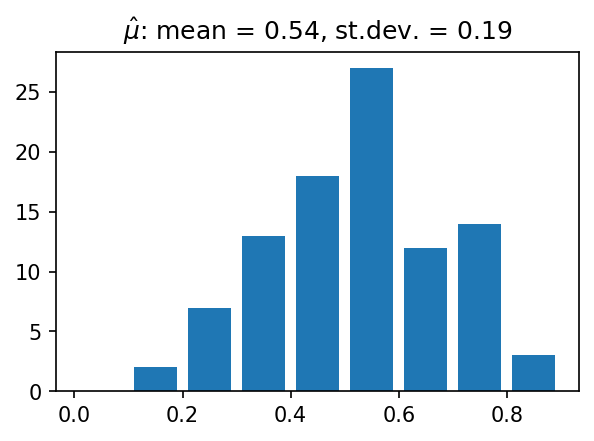

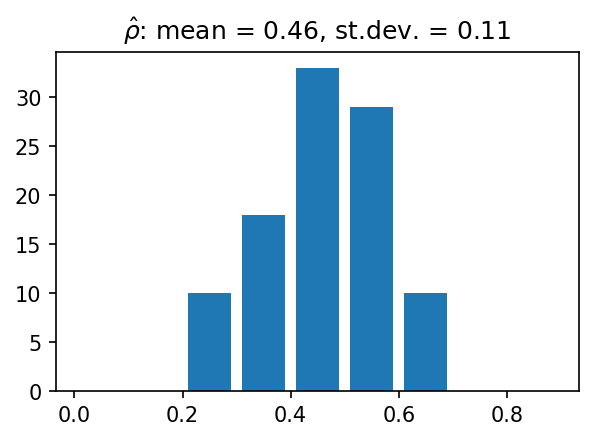

In [10]:
display(rs.describe())

for v in ['mu', 'rho']:
    plt.figure(dpi = 150, figsize = (4.5, 3))
    plt.hist(rs[v], bins = np.arange(0, 1, 0.1), rwidth = 0.8);
    vstr = '$\\hat{\\' + v + '}$'
    title = '{}: mean = {:.2f}, st.dev. = {:.2f}'.format(vstr, rs[v].mean(), rs[v].std()) 
    plt.title(title)
    plt.savefig(v+'.png')

## 6.2 Simulation with multiple manufactures

For the second simulation we use the following model:
$$Y_{i}^{k}=\beta_{d}\cdot F^{k}+\beta_{m}\cdot G^{m(k,i)}+\sqrt{1-\beta_{d}^2 -\beta_{m}^2}\cdot\varepsilon_{i}^{k}\ge\mu$$

$$F^k, G^m, \varepsilon_{i}^{k}\sim N(0,1)\ \ iid$$

Factors $F^k, k=1,\dots,K$ correspond to diseases and factors $G^m, m = 1,\dots,M$ correspond to different vaccine manufactures.

We first randomly split all vaccines into four groups corresponding to four different vaccine manufacturers. We then generate 10 samples of the above model with parameters equal to $\beta_d = 0.5$, $\beta_m = 0.5$, $\mu=0.5$ and for each sample estimate the parameters with maximum likelihood.

In [11]:
M = 4
K = len(outcomes) 

np.random.seed(0)
nvac = np.zeros((K, M), dtype = int)
for k in range(0, K):
    n = outcomes[k, 0]
    # we split vaccines with equal probabibility between manufacturers
    for i in range(0, n):
        nvac[k, np.random.randint(0, M)] += 1

print(nvac)

[[  2   2   0   5]
 [  0   0   0   1]
 [  1   1   1   1]
 [  3   1   3   1]
 [  3   5   1   2]
 [ 51  36  49  54]
 [  6  10   3   4]
 [ 34  43  28  39]
 [ 21  15  18  23]
 [  0   0   1   0]
 [  6   9   7  12]
 [  2   0   1   0]
 [  0   1   0   1]
 [  0   1   0   0]
 [  1   1   3   0]
 [  8   5   6   4]
 [ 10  12   7  10]
 [149 148 151 127]
 [ 14  14  17  16]
 [  3   1   5   4]
 [  0   1   0   0]
 [  3   3   2   2]
 [  0   1   0   0]
 [  0   1   3   0]
 [  7   8   2   8]
 [  1   0   0   1]]


In [12]:
def generate_sample_m(model, nvac):
    sigma = np.sqrt(1 - (model['beta_d'])**2 - (model['beta_m'])**2) 
    K = len(nvac) # number of diseases
    M = len(nvac[0]) # number of manufacturers
    sample = np.zeros((K, M, 2), dtype = int)
    F = np.random.normal(size = K)
    G = np.random.normal(size = M)
    for k in range(0, K):
        for m in range(0, M):
            sample[k, m, 0] = nvac[k, m]
            if nvac[k, m] == 0: continue
            eps = np.random.normal(size = nvac[k, m])
            Y = model['beta_d']*F[k] + model['beta_m']*G[m] + sigma*eps
            sample[k, m, 1] = sum(Y>=model['mu'])
    return sample
np.random.seed(0)
sample = []
for it in range(0, 20):
    sample.append(generate_sample_m({'beta_d': 0.5, 'beta_m': 0.5, 'mu': 0.5}, nvac))

In [13]:
def likelihood_m(mu, beta_d, beta_m, outcomes, mc = True, niter = 10, display = False):
    if beta_d**2 + beta_m**2 >= 1: return -np.inf
    sigma = np.sqrt(1 - beta_d**2 - beta_m**2)
    C = -mu/sigma; bd = beta_d/sigma; bm = beta_m/sigma
    K = len(outcomes);  M = len(outcomes[0])

    n = outcomes[:, :, 0]; ns = outcomes[:, :, 1]; nf = outcomes[:, :, 0] - outcomes[:, :, 1]
    factor = comb(n, ns)
    
    def prob_G(*G):
        Cm = C + np.resize(bm*np.array(G), (K, M))
        def prob_F(F):
            p = norm.cdf(Cm + np.resize(np.repeat(bd*F, M), (K,M)))
            prob = factor*(p**ns)*((1-p)**nf)
            return np.prod(prob, axis = 1)*norm.pdf(F)
        return np.prod(integrate.quad_vec(prob_F, -np.inf, np.inf)[0])
    
    if not mc: return np.log(integrate.quad(prob_G, -np.inf, np.inf)[0])
    
    sprob = 0; sprob2 = 0; np.random.seed(0)
    for it in range(0, niter):
        pG = prob_G(*np.random.normal(size = M))
        sprob += pG
        sprob2 += (pG**2)
    mean = sprob/niter
    std = np.sqrt(sprob2/niter - (mean**2))
    print(mean, std, std/mean)
    l = np.log(sprob/niter) if sprob != 0 else -np.inf
    if display:
        print('mu: {}, beta_d: {}, beta_m: {}, l: {}'.format(mu, beta_d, beta_m, l))
    return l

In [14]:
if False:
    def parameters_m(t):
        return {'mu': bnd(t[0], -1, 2), 'beta_d': bnd(t[1], 0.1, 0.9), 'beta_m': bnd(t[2], 0.1, 0.9)}

    resm = []; resm_info = []
    for it in range(0, 11):
        if it == 4: continue
        t0 = time.time()
        rm = optimize.minimize(lambda t: -likelihood_m(**parameters_m(t), niter = 10000, seed = it, outcomes = sample[it], display = False), x0 = [0, 0, 0])
        dt = time.time() - t0
        rm.l = -rm.fun # likelihood
        rm.p = parameters_m(rm.x) # parameters
        print('{} ({})'.format(it, calc_time(dt), rm.p))
        print({**rm.p, 'l': rm.l, 'dt': dt})
        resm.append({**rm.p, 'l': rm.l, 'dt': dt})
        resm_info.append({'message': rm.message, 'nfev': rm.nfev, 'nit': rm.nit, 'njev': rm.njev, 'status': rm.status, 'success': rm.success, 'x': rm.x})
else:
    resm = [#-likelihood_m(**parameters_m(t), niter = 10000, seed = it, outcomes = sample[it], display = False)
        {'mu': -0.0536287870269615, 'beta_d': 0.5331453472072017, 'beta_m': 0.3299192169000449, 'l': -130.4843991857505, 'dt': 46011.093168497086}, #0
        {'mu': 1.0020899714144442, 'beta_d': 0.3541326971968489, 'beta_m': 0.4966832442172875, 'l': np.nan, 'dt': 60089.723}, #1
        {'mu': 0.4126615023339302, 'beta_d': 0.4609175544561718, 'beta_m': 0.5130772305154225, 'l': np.nan, 'dt': 48722.593}, #2
        {'mu': 0.8066195626209482, 'beta_d': 0.5116491139856428, 'beta_m': 0.37780205473042616, 'l': np.nan, 'dt': 67554.195}, #3
        #{'mu': 0.8474719843952006, 'beta_d': 0.567712464638981, 'beta_m': 0.10000000490434909, 'l': np.nan, 'dt': 341856.714}, #4
        {'mu': 0.8236397194253762, 'beta_d': 0.47246772783419333, 'beta_m': 0.4948111018971787, 'l': -105.79824467110228, 'dt': 61677.57853937149}, #5
        {'mu': 0.7621508437450262, 'beta_d': 0.39927780800454993, 'beta_m': 0.5117858310064065, 'l': -89.76479815049268, 'dt': 57469.29870605469}, #6
        {'mu': 0.6888846604510035, 'beta_d': 0.6142107104251705, 'beta_m': 0.19199525075246446, 'l': -109.53195998504448, 'dt': 54893.91942644119}, #7
        {'mu': 0.9229124171411374, 'beta_d': 0.5196937857324541, 'beta_m': 0.19777807289467442, 'l': -103.87576826853389, 'dt': 36509.68911528587}, #8
        {'mu': 1.1379466759150025, 'beta_d': 0.3365781290083933, 'beta_m': 0.5264885606666388, 'l': -103.0960254396094, 'dt': 44770.68244314194}, #9
        {'mu': 0.5148508039170923, 'beta_d': 0.4945970872088189, 'beta_m': 0.5938860035557454, 'l': -98.49626076209327, 'dt': 47828.39555168152}, #10
        #{'mu': -0.23153854005356467, 'beta_d': 0.4874846512008304, 'beta_m': 0.1139659774797323, 'l': -137.83994876627816, 'dt': 60667.49683594704}, #11
        #{'mu': 0.46456896540476134, 'beta_d': 0.4890099465526223, 'beta_m': 0.5053872273216755, 'l': -107.28606092795246, 'dt': 36226.741322517395}, #12
    ]

print('resm = [')
for i in range(0, len(resm)): 
    if i<len(resm)-1:
        print('   ', resm[i], ',', sep = '')
    else: print('   ', resm[i], sep = '')
print(']')

display(pd.DataFrame(resm).describe())

resm = [
   {'mu': -0.0536287870269615, 'beta_d': 0.5331453472072017, 'beta_m': 0.3299192169000449, 'l': -130.4843991857505, 'dt': 46011.093168497086},
   {'mu': 1.0020899714144442, 'beta_d': 0.3541326971968489, 'beta_m': 0.4966832442172875, 'l': nan, 'dt': 60089.723},
   {'mu': 0.4126615023339302, 'beta_d': 0.4609175544561718, 'beta_m': 0.5130772305154225, 'l': nan, 'dt': 48722.593},
   {'mu': 0.8066195626209482, 'beta_d': 0.5116491139856428, 'beta_m': 0.37780205473042616, 'l': nan, 'dt': 67554.195},
   {'mu': 0.8236397194253762, 'beta_d': 0.47246772783419333, 'beta_m': 0.4948111018971787, 'l': -105.79824467110228, 'dt': 61677.57853937149},
   {'mu': 0.7621508437450262, 'beta_d': 0.39927780800454993, 'beta_m': 0.5117858310064065, 'l': -89.76479815049268, 'dt': 57469.29870605469},
   {'mu': 0.6888846604510035, 'beta_d': 0.6142107104251705, 'beta_m': 0.19199525075246446, 'l': -109.53195998504448, 'dt': 54893.91942644119},
   {'mu': 0.9229124171411374, 'beta_d': 0.5196937857324541, 'beta

,mu,beta_d,beta_m,l,dt
count,10.000000,10.000000,10.000000,7.000000,10.000000
mean,0.701813,0.469667,0.423423,-105.863922,52552.716795
std,0.341265,0.085576,0.141926,12.547941,9383.724771
min,-0.053629,0.336578,0.191995,-130.484399,36509.689115
25%,0.558359,0.414688,0.341890,-107.665102,46465.418764
50%,0.784385,0.483532,0.495747,-103.875768,51808.256213
75%,0.898094,0.517683,0.512754,-100.796143,59434.616927
max,1.137947,0.614211,0.593886,-89.764798,67554.195000
